# Homework 2: Denoising Auto Encoder with TensorFlow
--------- 
Nikolas Wolfe<br>
Deep Learning Seminar<br>
December 20th, 2015

## Problem 1
Download PASCAL VOC2007 dataset from VOC2007 website. This dataset includes training, validation and testing sets. You can fnd the images inside JPEGImages folder and the labels inside the ImageSets/Main folder.

I downloaded the VOC2007 dataset, and I have placed the train/test data in two folders:

In [1]:
%%bash
ls -l train/VOC2007/
ls -l test/VOC2007/

total 0
drwxr-xr-x  5013 nwolfe  staff  170442 Nov  6  2007 Annotations
drwxr-xr-x     6 nwolfe  staff     204 Dec 22 00:07 ImageSets
drwxr-xr-x  5013 nwolfe  staff  170442 Nov  6  2007 JPEGImages
drwxr-xr-x   424 nwolfe  staff   14416 Nov  6  2007 SegmentationClass
drwxr-xr-x   424 nwolfe  staff   14416 Nov  6  2007 SegmentationObject
total 0
drwxr-xr-x  4954 nwolfe  staff  168436 Nov  6  2007 Annotations
drwxr-xr-x     6 nwolfe  staff     204 Dec 22 00:22 ImageSets
drwxr-xr-x  4954 nwolfe  staff  168436 Nov  6  2007 JPEGImages
drwxr-xr-x   212 nwolfe  staff    7208 Nov  6  2007 SegmentationClass
drwxr-xr-x   212 nwolfe  staff    7208 Nov  6  2007 SegmentationObject


Together there are 2501 training images, 2510 validation images and 4952 testing images. Train a Denosing Autoencoder with different noise levels using the training set and visualize the learned filters as in here. Here you can use the whole image (re-size to a fixed size, e.g., 256x256) or sub-sampled small patches with a fixed size (e.g., 30x30). Comparing both of them will give you extra credits.
### Image Input Types to Test:
* 256 x 256 Resizing
* Convolutional sub-samples (30 x 30)

First, some imports and constants to make this easier down the line:
### Imports

In [2]:
# ------- TENSORFLOW --------- #
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import sys, os, numpy
from collections import defaultdict
from collections import OrderedDict

### Constants

In [3]:
# ------------------ General ------------------- #
IMG_DIR = 'VOC2007' + os.sep + 'JPEGImages' + os.sep
LBL_DIR = 'VOC2007' + os.sep + 'ImageSets' + os.sep + 'Main' + os.sep

# ------------------ Training ------------------ #
TRAIN_DIR = 'train' + os.sep + IMG_DIR
TRAIN_LABELS = 'train' + os.sep + LBL_DIR

# ------------------ Testing ------------------- # 
TEST_DIR = 'test' + os.sep + IMG_DIR
TEST_LABELS = 'test' + os.sep + LBL_DIR

# ------------------ Misc ------------------- # 
NUM_CLASSES = 20

In [4]:
print(TRAIN_DIR)
print(TRAIN_LABELS)
print(TEST_DIR)
print(TEST_LABELS)

train/VOC2007/JPEGImages/
train/VOC2007/ImageSets/Main/
test/VOC2007/JPEGImages/
test/VOC2007/ImageSets/Main/


The labels for the images are stored in the 'Main' directory, like so:

In [5]:
%%bash
ls train/VOC2007/ImageSets/Main/ | head -4

aeroplane_train.txt
aeroplane_trainval.txt
aeroplane_val.txt
bicycle_train.txt


The data in these files are in the following form, where the 1st column corresponds to the jpeg file and the 2nd column corresponds to whether the label is present, as shown in the output below:

In [6]:
%%bash
tail train/VOC2007/ImageSets/Main/bicycle_train.txt | head -4

009920 -1
009926  1
009938 -1
009940 -1


Just to verify this, we can look at somet of these files from the 'JPEGImages' folder:

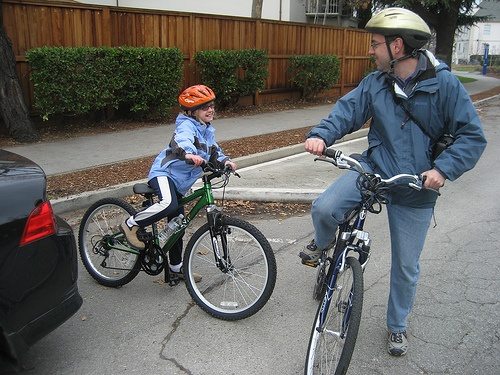

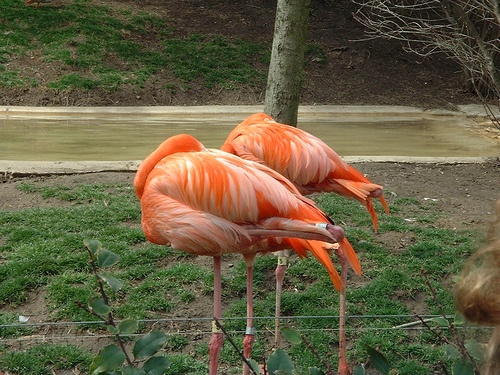

In [7]:
from IPython.display import Image
from IPython.display import display
x = Image(filename=TRAIN_DIR + '009926.jpg', width=256, height=256) # this IS a bicycle
y = Image(filename=TRAIN_DIR + '009940.jpg', width=256, height=256) # this is NOT a bicycle
display(x, y)

## Handling the Data
We first need to import the dataset and get it into the appropriate data structures which are used in TensorFlow. In this case I will not separate the training and validation sets.

In [8]:
# Generic read data from our file structure...
def get_data(DIR, LABELS, key):
    imgs = {}
    labels = defaultdict(list)
    for root, dirs, files in os.walk(LABELS, topdown=False):
        for f in files: 
            if '_' + key in f: 
                label = f.split('_')[0] 
                f = os.path.abspath(LABELS + f)
                pos_ex = [l.split()[0] for l in open(f).readlines() if l.split()[-1] == '1']
                for img in pos_ex:
                    labels[label].append(img)
                    imgs[img] = os.path.abspath(DIR + img + '.jpg')
    return imgs, labels

# Dig through for the training data...
def get_train_data(): return get_data(TRAIN_DIR, TRAIN_LABELS, "trainval.txt")        

# Dig through for the testing data...
def get_test_data(): return get_data(TEST_DIR, TEST_LABELS, "test.txt")        

Read in train and test data...

In [9]:
# --------- TRAIN & TEST SETS --------- #
train_imgs, train_labels = get_train_data()
test_imgs, test_labels = get_test_data()

For use in classification later on, we're going to find it useful to have 20-dimensional 1-hot bit vectors to represent our 20 PASCAL classification labels. So we'll go ahead and create those representations here:

In [10]:
def get_one_hot_label_list(label_dict):
    keys = OrderedDict(sorted(label_dict.items())).keys()
    one_hot_lookup = {}
    for i in range(len(keys)):
        one_hot = numpy.zeros(NUM_CLASSES)
        one_hot[i] = 1
        one_hot_lookup[keys[i]] = one_hot
    one_hot_list = []
    for label in label_dict.keys():
        vals = label_dict[label]
        for v in vals:
            one_hot_list.append((v, one_hot_lookup[label]))
    return one_hot_list

This will create a mapping between the image keys and the one-hot labels. We add a duplicate image key entry to the list if the image contains more than one label.

In [11]:
train_labels_one_hot = get_one_hot_label_list(train_labels)
test_labels_one_hot = get_one_hot_label_list(test_labels)

Now we need to read in the images and create TensorFlow tensors with them... In this function we will associate the one-hot dictionaries with the files their keys point to. As per the requirements of the first part of this assignment, we will also call an operation to resize the images to 256 x 256 pixels.

In [12]:
def read_img_data(one_hot_dict, file_dict):
    labels = []
    files = []
    img_files = []
    reader = tf.WholeFileReader()
    print('Assembling files...')
    for (img, label_vec) in one_hot_dict:
        files.append(file_dict[img])
        labels.append(label_vec)
    queue = tf.train.string_input_producer(files)
    jpg_key, jpg_img = reader.read(queue)
    jpg_img = tf.image.decode_jpeg(jpg_img)
    init = tf.initialize_all_variables()
    # Run session...
    print('Starting tensorflow session...')
    with tf.Session() as sess:
        with tf.device('/cpu:0'):
            sess.run(init)
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(coord=coord)
            for i in range(len(files)):
                jpg = jpg_img.eval()
                img_files.append(jpg)
            coord.request_stop()
            coord.join(threads)
        
    # build numpy arrays
    print('Reconstructing arrays...')
    img_files = numpy.asarray(img_files)
    labels = numpy.asarray(labels)
    print('Done!')
    return img_files, labels

In [13]:
read_img_data(train_labels_one_hot, train_imgs)

Assembling files...
Starting tensorflow session...
Reconstructing arrays...
Done!


(array([ array([[[238, 249, 241],
         [239, 249, 248],
         [244, 254, 255],
         ..., 
         [247, 253, 251],
         [247, 253, 251],
         [247, 253, 251]],
 
        [[226, 236, 237],
         [247, 255, 255],
         [240, 250, 251],
         ..., 
         [247, 253, 251],
         [247, 253, 251],
         [247, 253, 251]],
 
        [[216, 224, 235],
         [244, 253, 255],
         [240, 250, 249],
         ..., 
         [247, 253, 251],
         [247, 253, 251],
         [247, 253, 251]],
 
        ..., 
        [[122, 127, 131],
         [123, 128, 132],
         [126, 131, 135],
         ..., 
         [130, 138, 141],
         [132, 140, 143],
         [134, 142, 145]],
 
        [[114, 119, 123],
         [116, 121, 125],
         [124, 129, 133],
         ..., 
         [157, 164, 170],
         [165, 172, 178],
         [168, 175, 181]],
 
        [[141, 146, 150],
         [132, 137, 141],
         [128, 133, 137],
         ..., 
         [160, 

## Building An AutoEncoder
The first step on this journey is to download and install a few packages we will need. I will be building this project using Google <a href="https://www.tensorflow.org/">TensorFlow</a>

In [14]:
An Auto-encoder w

SyntaxError: invalid syntax (<ipython-input-14-40481cd49ab2>, line 1)

In [ ]:
""" Deep Auto-Encoder implementation
	
	An auto-encoder works as follows:
	Data of dimension k is reduced to a lower dimension j using a matrix multiplication:
	softmax(W*x + b)  = x'
	
	where W is matrix from R^k --> R^j
	A reconstruction matrix W' maps back from R^j --> R^k
	so our reconstruction function is softmax'(W' * x' + b') 
	Now the point of the auto-encoder is to create a reduction matrix (values for W, b) 
	that is "good" at reconstructing  the original data. 
	Thus we want to minimize  ||softmax'(W' * (softmax(W *x+ b)) + b')  - x||
	A deep auto-encoder is nothing more than stacking successive layers of these reductions.
"""

## Problem 2
Given the PASCAL dataset from Part 1, train a Stacked Denosing Autoencoder
as in here using the training set and use it as:

* A fixed network to extract features. Train RBF SVMs using the extracted features from the training set. Again, here you can use a small network trained with sub-sampled inputs and average the output of the network to get image-level features when you train the SVMs.

* A pre-trained network to initialize a feed-forward network and finne-tune the feed-forward network using the training set. Here you will have to use the whole re-sized images as the inputs. Given the fact that an image may have multiple labels in this dataset, you may not want to use a softmax layer as your output layer. Explore the network structure and SVM parameters to achieve the best validation accuracy (mAP for SVM) you can get. Report the best network structure, SVM parameters the corresponding testing MAP.